## No space left on disk

When the disk is too full to even start the VM instance and repair, that’s when you need to create another instance, attach the system disk to it, and use the helper instance to do the resizing.

### Step 1: Make a snapshot of the VM disk

Keep it the same size.

### Step 2: Make a disk from the snapshot

Resize it to the size you want.

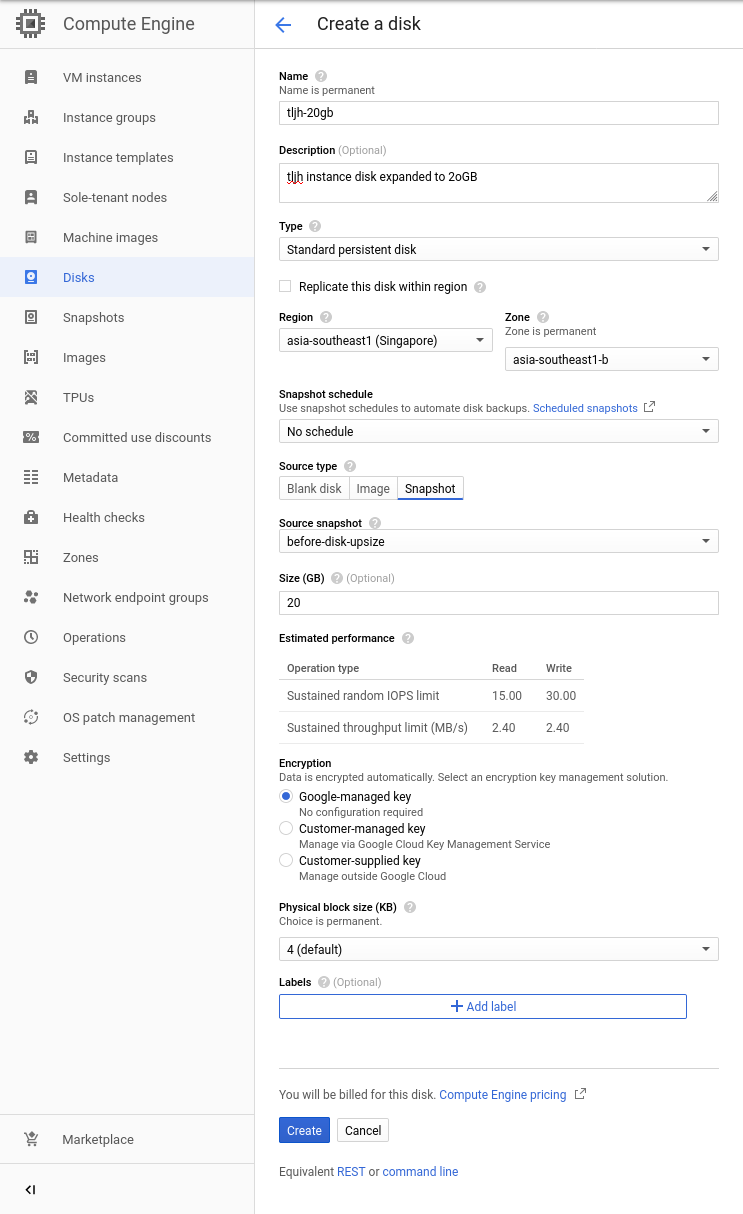

Now we need to expand the partition to fill the entire disk.

### Step 3: Create a VM instance to help with resizing

This VM instance does not need high specs, it just needs to be SSH-able. It helps to set `enable-oslogin=TRUE` in instance metadata.

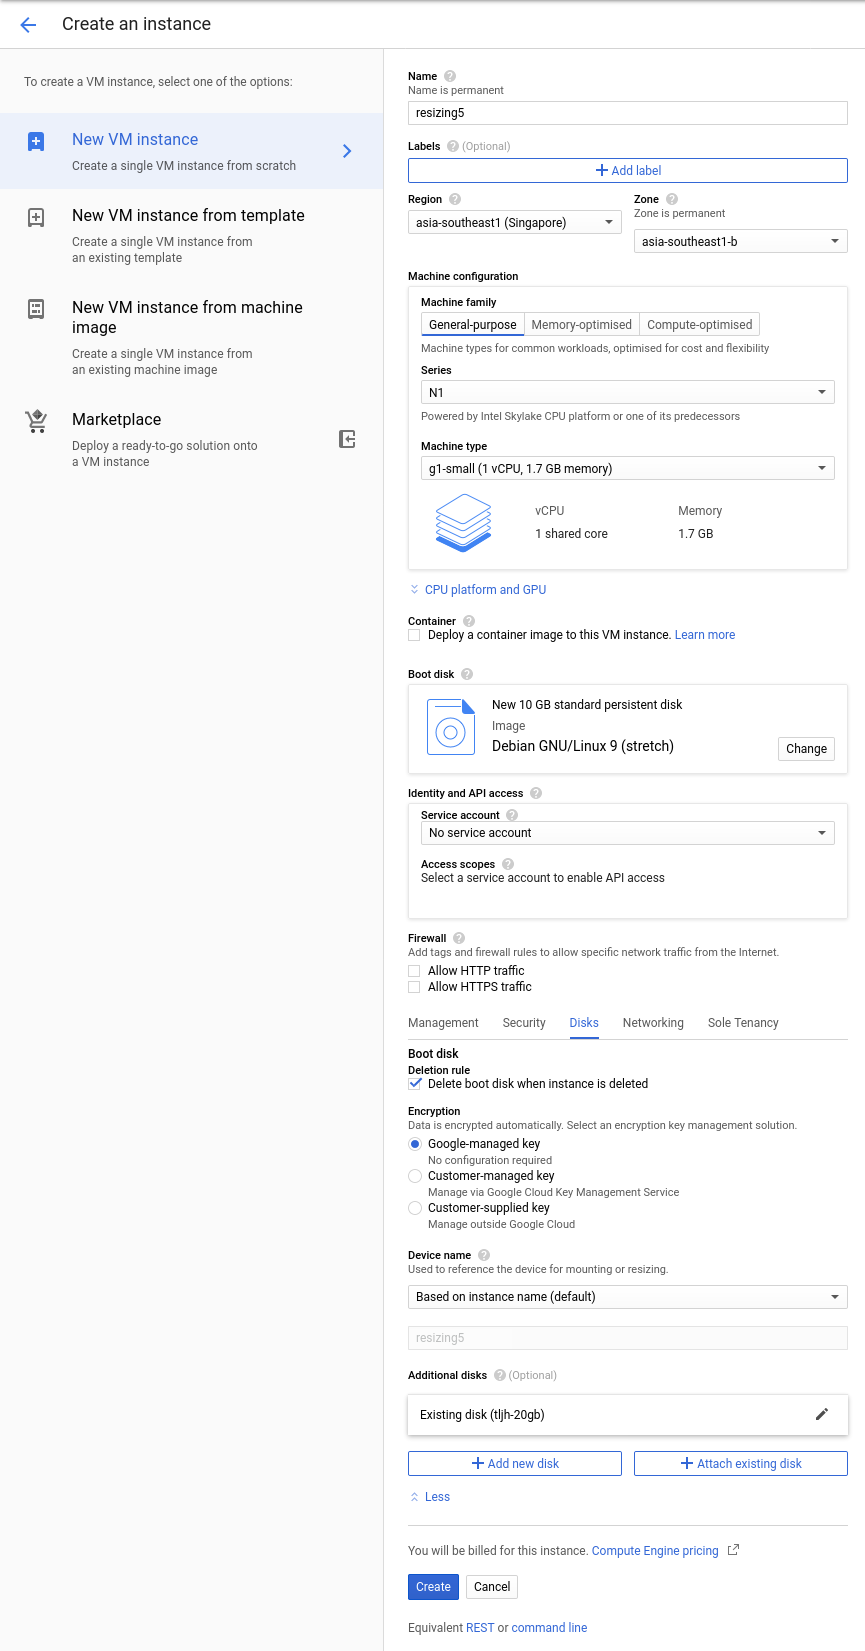

Open a shell via SSH and run the following commands:

In [ ]:
username@resizing5:~$ sudo lsblk
NAME    MAJ:MIN RM  SIZE RO TYPE MOUNTPOINT
sda       8:0    0   10G  0 disk 
└─sda1    8:1    0   10G  0 part /
sdb       8:16   0   20G  0 disk            # This is the target disk
├─sdb1    8:17   0  9.9G  0 part 
├─sdb14   8:30   0    4M  0 part 
└─sdb15   8:31   0  106M  0 part 
username@resizing5:~$ sudo apt -y install cloud-guest-utils
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cloud-guest-utils is already the newest version (0.29-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
username@resizing5:~$ sudo growpart /dev/sdb 1
CHANGED: partition=1 start=227328 old: size=20744159 end=20971487 new: size=41715679,end=41943007
username@resizing5:~$ sudo lsblk
NAME    MAJ:MIN RM  SIZE RO TYPE MOUNTPOINT
sda       8:0    0   10G  0 disk 
└─sda1    8:1    0   10G  0 part /
sdb       8:16   0   20G  0 disk 
├─sdb1    8:17   0 19.9G  0 part            # Now resized
├─sdb14   8:30   0    4M  0 part 
└─sdb15   8:31   0  106M  0 part 
username@resizing5:~$ e2fsck -f /dev/sd1
-bash: e2fsck: command not found
username@resizing5:~$ sudo apt -y install e2fsck-static
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  sash
Suggested packages:
  doc-debian
The following NEW packages will be installed:
  e2fsck-static sash
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 977 kB of archives.
After this operation, 2,529 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian stretch/main amd64 e2fsck-static amd64 1.43.4-2+deb9u1 [619 kB]
Get:2 http://deb.debian.org/debian stretch/main amd64 sash amd64 3.8-3+b7 [358 kB]
Fetched 977 kB in 0s (1,354 kB/s)
Selecting previously unselected package e2fsck-static.
(Reading database ... 38685 files and directories currently installed.)
Preparing to unpack .../e2fsck-static_1.43.4-2+deb9u1_amd64.deb ...
Unpacking e2fsck-static (1.43.4-2+deb9u1) ...
Selecting previously unselected package sash.
Preparing to unpack .../sash_3.8-3+b7_amd64.deb ...
Unpacking sash (3.8-3+b7) ...
Setting up e2fsck-static (1.43.4-2+deb9u1) ...
Setting up sash (3.8-3+b7) ...
Processing triggers for man-db (2.7.6.1-2) ...
username@resizing5:~$ sudo e2fsck -f /dev/sdb1
e2fsck 1.43.4 (31-Jan-2017)
cloudimg-rootfs: recovering journal
Pass 1: Checking inodes, blocks, and sizes
Pass 2: Checking directory structure
Pass 3: Checking directory connectivity
Pass 4: Checking reference counts
Pass 5: Checking group summary information
cloudimg-rootfs: 353695/1290240 files (0.2% non-contiguous), 2588923/2593019 blocks
username@resizing5:~$ sudo resize2fs /dev/sdb1
resize2fs 1.43.4 (31-Jan-2017)
Resizing the filesystem on /dev/sdb1 to 5214459 (4k) blocks.
The filesystem on /dev/sdb1 is now 5214459 (4k) blocks long.

### Step 4: Detach target disk from resizing instance

Just edit instance (no need to shut down) and remove the disk (click bin icon)

### Step 5: Create new VM instance with same settings, but with the recreated disk

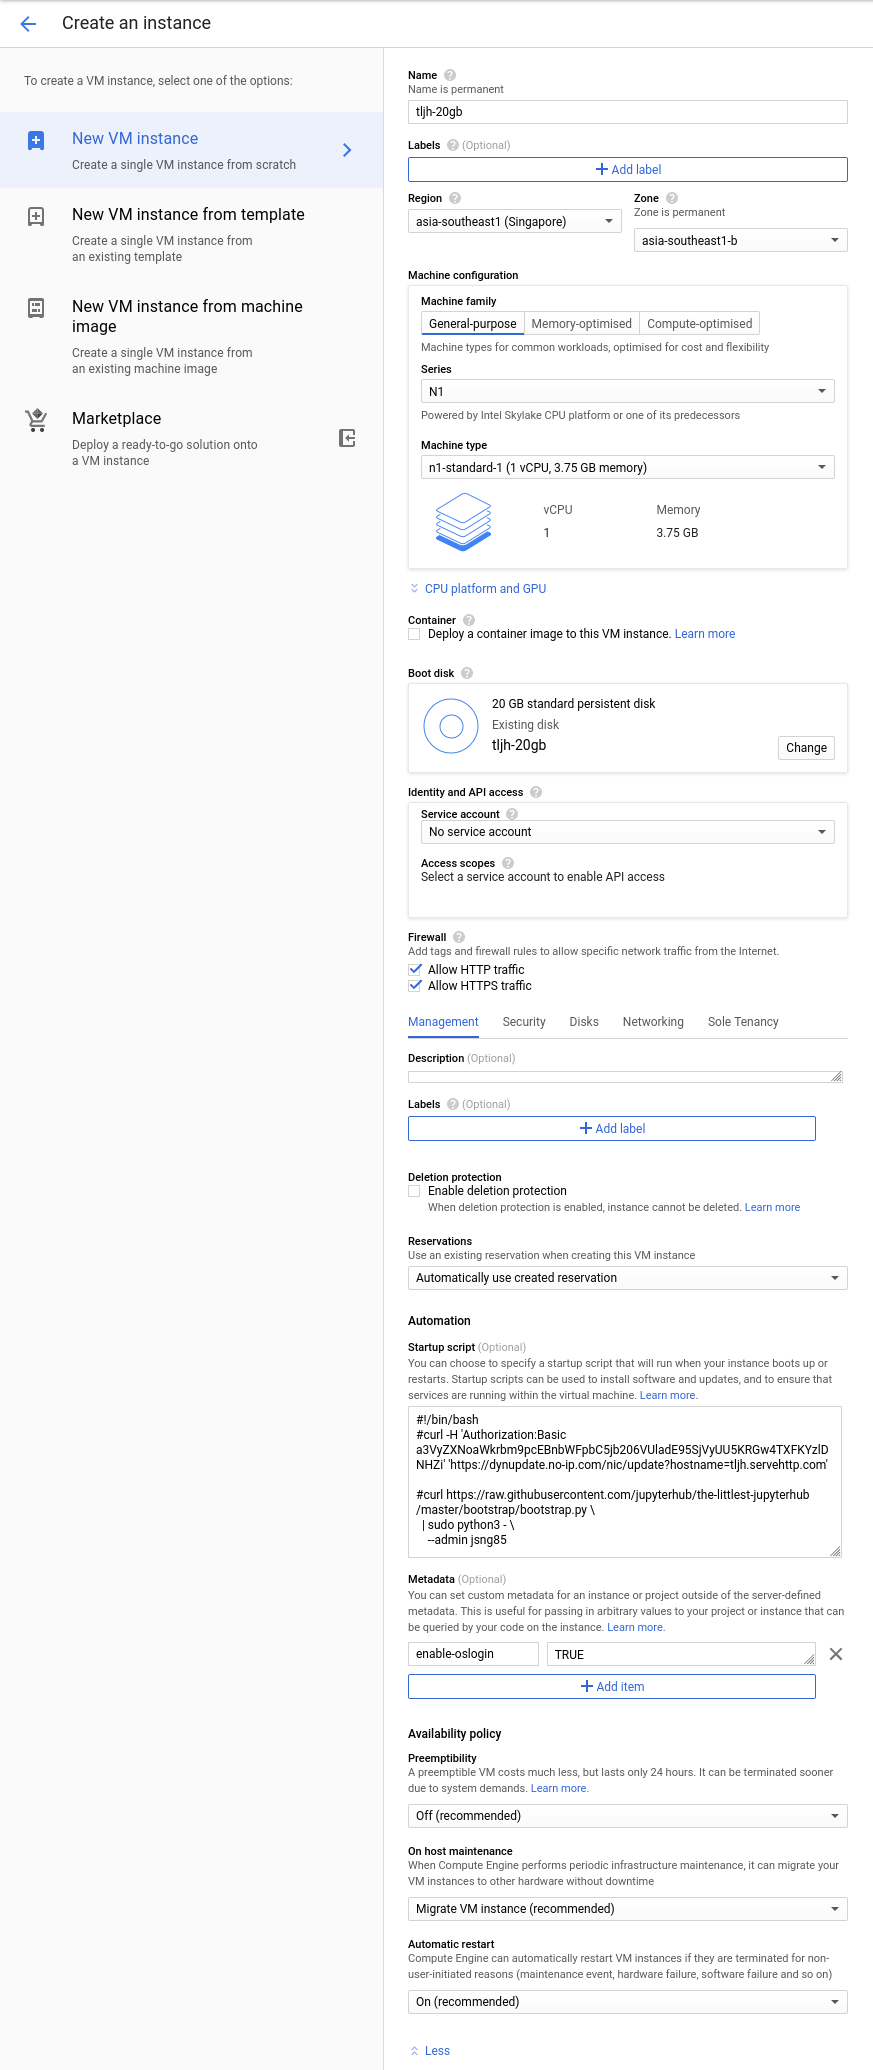

### Step 6: Set `journalctl` to clean up upon startup

Add the following line to the startup script:

    sudo journalctl --vacuum-time=7d